---
---

## DHS2019 DATA EXPLORATION PART 2

---

#### PROBLEM STATEMENT

Recent years have witnessed a surge in the number of internet savvy users. Companies in the financial services domain leverage this huge internet traffic arriving at their interface by strategically placing ads/promotions for cross selling of various financial products on a plethora of web pages. The digital analytics unit of Best Cards Company uses cutting edge data science and machine learning for successful promotion of its valuable card products. They believe that a predictive model that forecasts whether a session involves a click on the ad/promotion would help them extract the maximum out of the huge clickstream data that they have collected. You are hired as a consultant to build an efficient model to predict whether a user will click on an ad or not, given the following features:

   - Clickstream data/train data for duration: (2nd July 2017 – 7th July 2017)
   - Test data for duration: (8th July 2017 – 9th July 2017)
   - User features (demographics, user behaviour/activity, buying power etc.)
   - Historical transactional data of the previous month with timestamp info (28th May 2017– 1st July 2017). This data contains actions (views/interest registered) taken by the user historically on the product page via an ad or other sources
   - Ad features (product category, webpage, campaign for ad etc.)
   - Date time features (exact timestamp of the user session)
   
   
---


***DATASET URL: https://datahack.analyticsvidhya.com/contest/workshop_amexpert-2018-machine-learning-hackathon/***

In [0]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

%matplotlib inline

In [0]:
# read the train and test data from the amex_complete_data
train_df = pd.read_csv("dataset/amex_sample_data/train_sample.csv", parse_dates=["DateTime"])
test_df = pd.read_csv("dataset/amex_sample_data/test_sample.csv", parse_dates=["DateTime"])
print(train_df.shape, test_df.shape)

(463291, 15) (128858, 14)


In [0]:
train_df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [0]:
test_df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1
0,411705,2017-07-08,732573,J,404347,53587,1,NaN,5.0,Male,5.0,3.0,NaN,0
1,208263,2017-07-08,172910,I,118601,28529,3,82527.0,NaN,NaN,NaN,NaN,NaN,1
2,239450,2017-07-08,172910,I,118601,28529,4,82527.0,NaN,NaN,NaN,NaN,NaN,1
3,547761,2017-07-08,557318,G,118601,28529,5,82527.0,1.0,Male,1.0,3.0,1.0,0
4,574275,2017-07-08,923896,H,118601,28529,5,82527.0,9.0,Female,3.0,1.0,NaN,1


---

#### TARGET EXPLORATION

---

In [0]:
### EXERCISE-1
# value count of the target variable
train_df.is_click.value_counts()

0    431960
1     31331
Name: is_click, dtype: int64

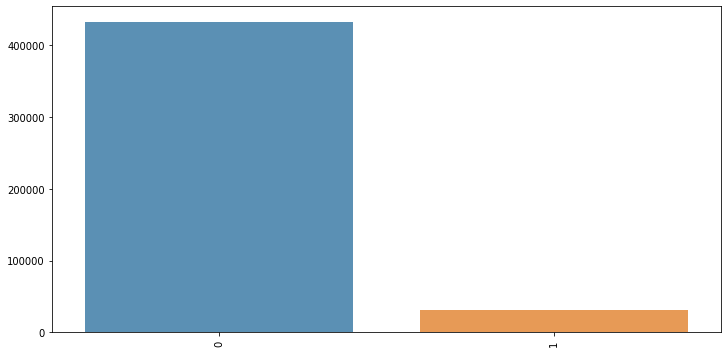

In [0]:
### EXERCISE-2
# do a bar plot of the target variable value count
cnt_srs = train_df.is_click.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.show()

In [0]:
### EXERCISE-3
# find number of users common in train and test data
train_users = set(train_df.user_id.unique())
test_users = set(test_df.user_id.unique())
print('Unique Users in Train Data: ', len(train_users))
print('Unique Users in Test Data: ', len(test_users))
print('Users in Both Train and Test Data',len(train_users.intersection(test_users)))

Unique Users in Train Data:  150347
Unique Users in Test Data:  66502
Users in Both Train and Test Data 39120


In [0]:
### EXERCISE-4
# read the historical_user_logs_sample.csv
logs_users = pd.read_csv("dataset/amex_sample_data/historical_user_logs_sample.csv", usecols=["user_id"])

In [0]:
# find number of unique users in log data
logs_users = logs_users["user_id"].unique()

In [0]:
print("Unique users in log data: ", len(logs_users))

Unique users in log data:  154881


In [0]:
### EXERCISE-5
# common users in log data and train data
print("Common no. of users between logs and train : ",len(set(logs_users).intersection(train_users)))

Common no. of users between logs and train :  132605


In [0]:
### EXERCISE-6
# commmon users in log data and test data
print("Common no. of users between logs and test : ",len(set(logs_users).intersection(test_users)))

Common no. of users between logs and train :  57732


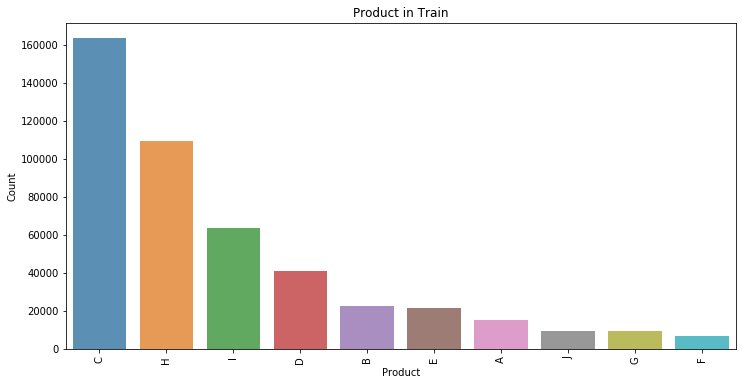

In [0]:
### EXERCISE-7
## Do a bar plot for products present in train set
cnt_srs = train_df["product"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Product")
plt.ylabel("Count")
plt.title("Product in Train")
plt.show()

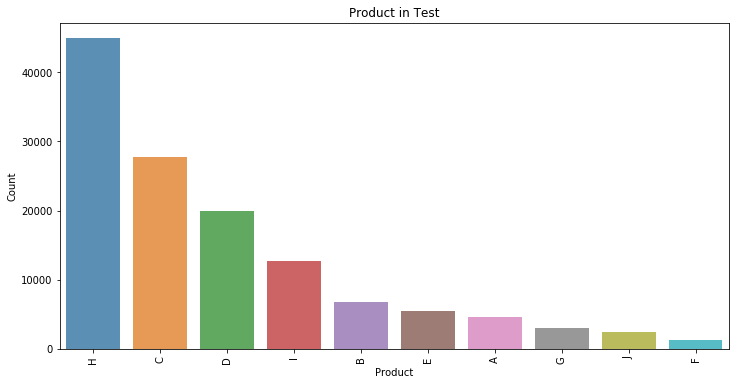

In [0]:
## Do a bar plot for products present in test set
cnt_srs = test_df["product"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Product")
plt.ylabel("Count")
plt.title("Product in Test")
plt.show()

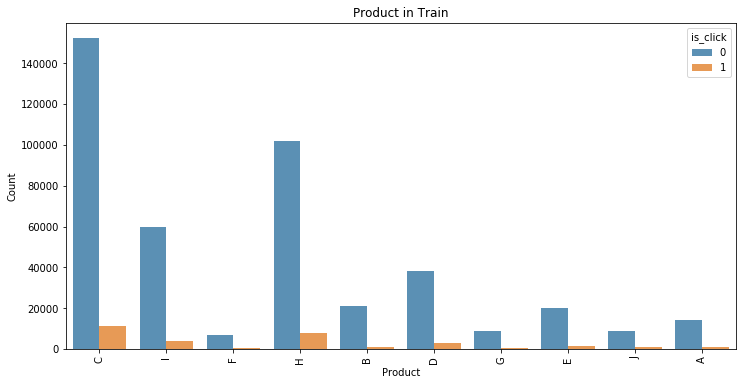

In [0]:
### EXERCISE-8
## Count plot for product with 'is_click' as hue
plt.figure(figsize=(12,6))
sns.countplot(data=train_df, x="product", hue="is_click", alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Product")
plt.ylabel("Count")
plt.title("Product in Train")
plt.show()

---

#### CAMPAIGN EXPLORATION

---

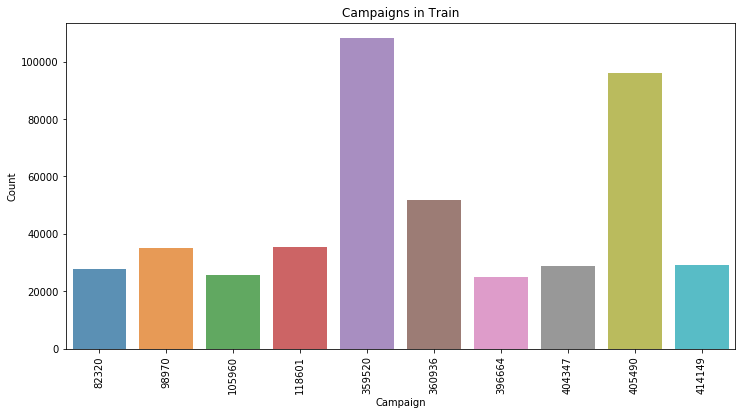

In [0]:
### EXERCISE-9
## Do a bar plot for campaigns in train
cnt_srs = train_df["campaign_id"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Campaign")
plt.ylabel("Count")
plt.title("Campaigns in Train")
plt.show()

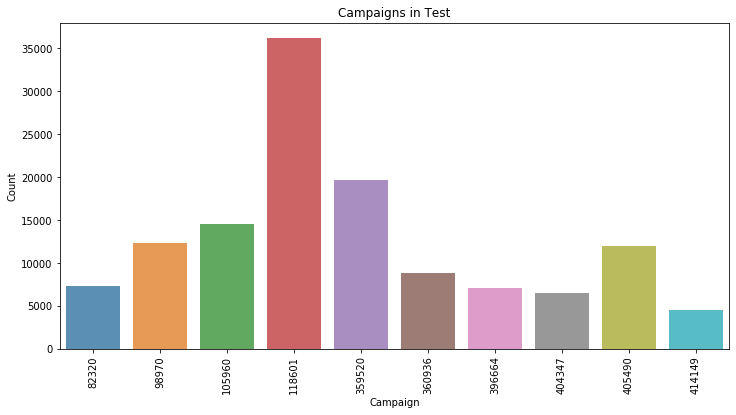

In [0]:
## Do a bar plot for campaigns in test
cnt_srs = test_df["campaign_id"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Campaign")
plt.ylabel("Count")
plt.title("Campaigns in Test")
plt.show()

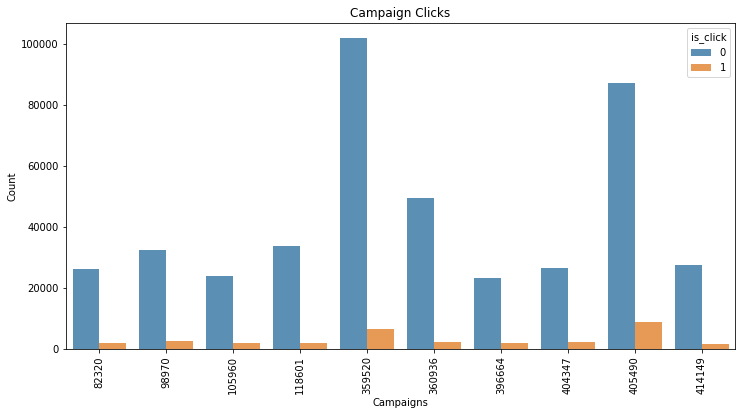

In [0]:
## Count plot for campaigns with 'is_click' as hue in train
plt.figure(figsize=(12,6))
sns.countplot(data=train_df, x="campaign_id", hue="is_click", alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Campaigns")
plt.ylabel("Count")
plt.title("Campaign Clicks")
plt.show()

---
##### Figure out the relations between campaign id and webpage id
---

In [0]:
### EXERCISE-10
## Check out the relationship between campaign_id and webpage_id 
gdf = train_df.groupby(["campaign_id", "webpage_id"])["session_id"].count().reset_index()
gdf.columns = ["campaign_id", "webpage_id", "count"]
gdf

,campaign_id,webpage_id,count
0,82320,1734,27849
1,98970,6970,35065
2,105960,11085,25781
3,118601,28529,35531
4,359520,13787,108155
5,360936,13787,51888
6,396664,51181,24909
7,404347,53587,28826
8,405490,60305,95973
9,414149,45962,29314


---
#### Relationship between Product & Product Category

***Is there one to one relationship between product and product category?***

---

In [0]:
### EXERCISE-11
## Is there one to one relationship between product and product category 1? 
train_df.groupby(["product","product_category_1"])["session_id"].count()

product  product_category_1
A        1                      5236
         2                      7727
         3                       206
         4                      2222
B        1                      2876
         2                     16397
         3                      1188
         4                      2017
         5                         1
C        1                      5430
         2                      4390
         3                     70930
         4                     48759
         5                     33992
D        1                      3669
         2                      4588
         3                      1151
         4                     25919
         5                      5737
E        1                     10752
         2                     10700
F        1                      1380
         2                      1655
         3                      3906
         4                         4
         5                        62
G        1

In [0]:
## Is there one to one relationship between product and product category 2? 
train_df.groupby(["product","product_category_2"])["session_id"].count()

product  product_category_2
A        82527.0               2222
         143597.0              1958
         146115.0               490
         234846.0                 4
         247789.0                 1
                               ... 
I        270915.0              2369
         327439.0                 4
         419804.0                43
J        269093.0               858
         450184.0                14
Name: session_id, Length: 67, dtype: int64

---

#### Age Level

***Check the age level in the dataset***

---

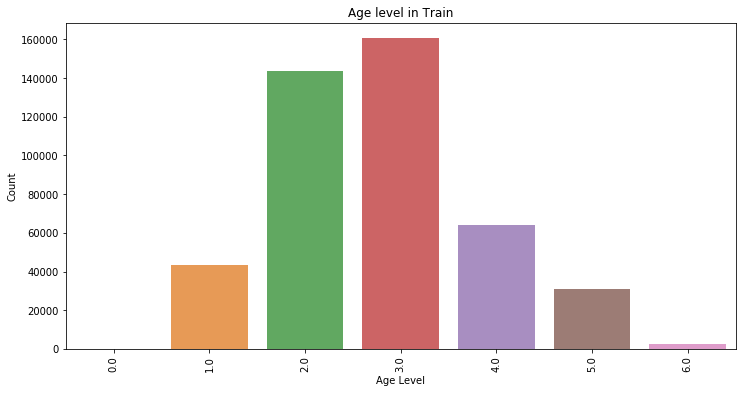

In [0]:
### EXERCISE-12
## Do a bar plot for age_level in train
cnt_srs = train_df["age_level"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Age Level")
plt.ylabel("Count")
plt.title("Age level in Train")
plt.show()

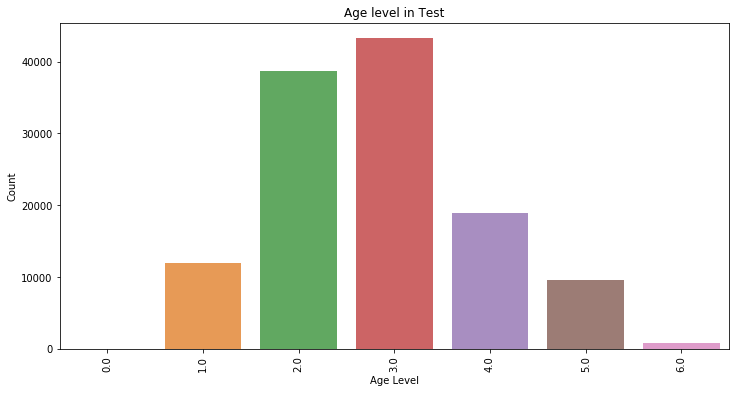

In [0]:
## Do a bar plot for age_level in test
cnt_srs = test_df["age_level"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Age Level")
plt.ylabel("Count")
plt.title("Age level in Test")
plt.show()

---
---

## Temporal Exploration

- **Check out the dates present in train and test data**

- **Also the number of rows for each day**

In [0]:
### EXERCISE-13
## Extract the Date from the DateTime column

train_df["Date"] = train_df["DateTime"].dt.date
test_df["Date"] = test_df["DateTime"].dt.date

## Get the number of rows for each day in train set

train_df["Date"].value_counts()

2017-07-03    81380
2017-07-05    80789
2017-07-02    79045
2017-07-06    77526
2017-07-04    73085
2017-07-07    71466
Name: Date, dtype: int64

In [0]:
## Get the number of rows for each day in test set

test_df["Date"].value_counts()

2017-07-08    66874
2017-07-09    61984
Name: Date, dtype: int64

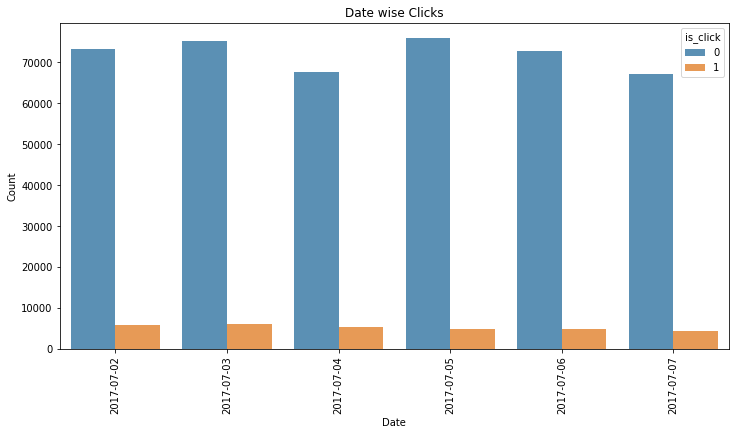

In [0]:
### EXERCISE-14
## Count plot for Date with 'is_click' as hue in train
plt.figure(figsize=(12,6))
sns.countplot(data = train_df, x = "Date", hue = "is_click", alpha = 0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Date wise Clicks")
plt.show()